In [1]:
import random
import time
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from copy import deepcopy
from typing import Dict, List, Tuple
import itertools

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as ticker

In [3]:
# Load DCIts
import sys
import os
sys.path.append('..')
from src.dcits import DCITS

In [4]:
# Load utils
from src.utils import *

In [5]:
# Set random seeds for reproducibility
seed = 1000

In [6]:
# Check if CUDA is available
if torch.cuda.is_available():
    # Specify the device (index starts from 0, so cuda:0 is the first GPU)
    device = torch.device("cuda:0")
    print(f"Using {torch.cuda.get_device_name(device)}")
else:
    print("CUDA is not available. Using CPU instead.")
    device = torch.device("cpu")

Using NVIDIA RTX A4000


## Data generation parameters

In [7]:
no_of_timeseries = 3
window_length = 5
a = 3.75  # Parameter 'a' from the cubic map
mean = 0
std = 0.1
frequency = 0.3 # Ako stavim na 0.3 dobijem samo nan-ove
ts_length = 20000

# Cubic map

Process inspired by Cubic map $X_t=aX_{t-1}^3 + (1-a)X_{t-1}$ with $a=3.75$:
\begin{align*}
X_{1,t} &= (1-a)X_{1,t-3} + a X_{1,t-3}^3 + \epsilon_{1,t} \\
X_{2,t} &= (1-a)X_{2,t-5} + a X_{2,t-5}^3 + \epsilon_{2,t} \\
X_{3,t} &= \frac{1}{2}(X_{3,t-3} + X_{3,t-5}) + \epsilon_{3,t}.
\end{align*}     

In [8]:
def dataset(len_of_timeseries, ground_truth_alpha_linear, ground_truth_alpha_cubic, bias, noise_frequency=0, mu=0, sigma=1, burn_in=1000, seed=None):
    """
    Generates a multivariate time series based on specified linear and cubic equations with reproducible noise.
    Args:
        len_of_timeseries (int): Length of the time series to generate
        ground_truth_alpha_linear (torch.Tensor): Coefficients tensor for linear terms, shape (no_of_timeseries, no_of_timeseries, window_length)
        ground_truth_alpha_cubic (torch.Tensor): Coefficients tensor for cubic terms, shape (no_of_timeseries, no_of_timeseries, window_length)
        bias (torch.Tensor): Bias term for each time series component, shape (no_of_timeseries,)
        noise_frequency (float): Probability of adding noise at each step (0 to 1)
        mu (float): Mean of the Gaussian noise
        sigma (float): Standard deviation of the Gaussian noise
        burn_in (int): Number of initial samples to discard
        seed (int, optional): Seed for random number generation for reproducibility
    Returns:
        torch.Tensor: Generated time series of shape (no_of_timeseries, len_of_timeseries)
    """
    if seed is not None:
        np.random.seed(seed)
        torch.manual_seed(seed)
    
    clip_count=0
    clip_count_occurences=0
    # Set dimensions    
    no_of_timeseries, window_length = ground_truth_alpha_linear.shape[-2:]
    total_length = len_of_timeseries + burn_in
    
    # Initialize all values with uniform random values in [-0.9999, 0.9999]
    time_series = torch.empty((no_of_timeseries, total_length)).uniform_(-0.9999, 0.9999)
    
    # Generate noise mask and noise
    noise_mask = (np.random.rand(no_of_timeseries, total_length - window_length) < noise_frequency)
    noise_after_window = np.random.normal(mu, sigma, (no_of_timeseries, total_length - window_length)) * noise_mask
    noise_after_window = torch.tensor(noise_after_window, dtype=torch.float32)
    
    # Insert noise into time series (after window_length)
    time_series[:, window_length:] = noise_after_window
    
    # Populate the time series based on lagged values
    for t in range(window_length, total_length):
        # Get all relevant lags at once: shape (no_of_timeseries, window_length)
        # Flip to properly align the lags (most recent first)
        lagged_values = time_series[:, t-window_length:t].flip(1)
        
        # Compute linear and cubic lagged sums using einsum
        lagged_sum_linear = torch.einsum('ijk,jk->i', ground_truth_alpha_linear, lagged_values)
        lagged_sum_cubic = torch.einsum('ijk,jk->i', ground_truth_alpha_cubic, lagged_values ** 3)
        
        # Combine linear and cubic terms
        transition_value = lagged_sum_linear + lagged_sum_cubic + bias
        
        # Update time_series at time t (add transition value to the existing noise)
        time_series[:, t] = transition_value + time_series[:, t]
        if (time_series[:, t]>1).any():
            clip_count=clip_count+sum(time_series[:,t]>1)
            clip_count_occurences=clip_count_occurences+1
        time_series[:, t]=np.clip(time_series[:, t],-1,1)
        
    print(f'Data was clipped {clip_count} times on {clip_count_occurences} unique occurences')
        
    # Drop the burn-in samples
    return time_series[:, burn_in:]

In [9]:


# Initialize ground_truth_alpha tensors for linear and cubic terms
ground_truth_alpha_linear = torch.zeros(no_of_timeseries, no_of_timeseries, window_length)
ground_truth_alpha_cubic = torch.zeros(no_of_timeseries, no_of_timeseries, window_length)

ground_truth_alpha_linear[0, 0, 2] = (1 - a)
ground_truth_alpha_linear[1, 1, 4] = (1 - a)
ground_truth_alpha_linear[2, 0, 2] = 0.5
ground_truth_alpha_linear[2, 1, 4] = 0.5 
alpha_mask_linear = (ground_truth_alpha_linear != 0).float()  # 1 where there's a non-zero value, 0 otherwise

# Cubic part
ground_truth_alpha_cubic[0, 0, 2] = a
ground_truth_alpha_cubic[1, 1, 4] = a
alpha_mask_cubic = (ground_truth_alpha_cubic != 0).float()  # 1 where there's a non-zero value, 0 otherwise

ground_truth_bias = torch.zeros(no_of_timeseries)

# Generate the time series
time_series = dataset(
    len_of_timeseries=ts_length,
    ground_truth_alpha_linear=ground_truth_alpha_linear,
    ground_truth_alpha_cubic=ground_truth_alpha_cubic,
    bias=ground_truth_bias,
    noise_frequency=frequency,
    mu=mean,
    sigma=5 * std,
    burn_in=1000,
    seed=None
)

Data was clipped 2363 on 2258 unique occurences


In [10]:
ground_truth_beta_linear = torch.abs(ground_truth_alpha_linear).sum(axis=-1)
ground_truth_beta_cubic = torch.abs(ground_truth_alpha_cubic).sum(axis=-1)

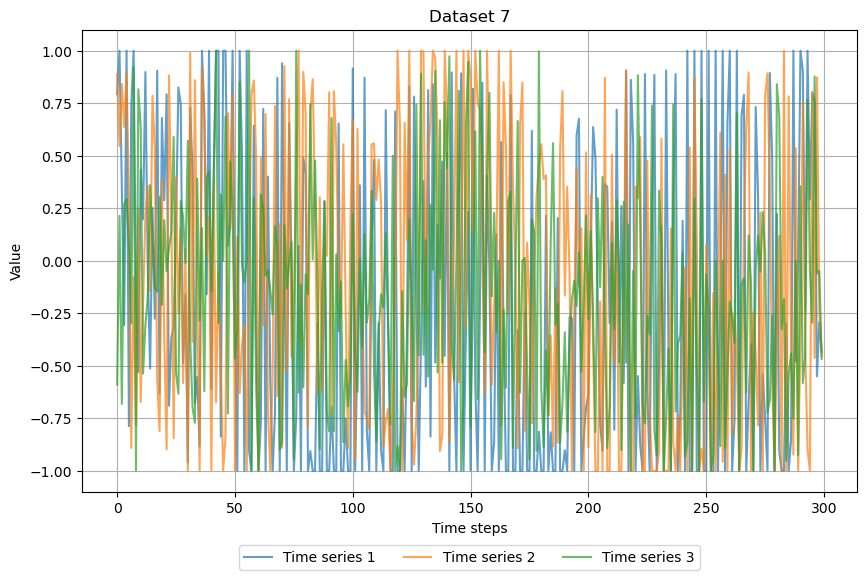

In [11]:
plot_ts(time_series[:,:300], dataset_name="Dataset 7",alpha=0.7)

In [12]:
(torch.min(time_series),torch.max(time_series))

(tensor(-1.), tensor(1.))

# Train 

In [13]:
train_config = {
    'verbose': True,
    'device' : device,
    'learning_rate': 1e-3,
    'scheduler_patience': 5,
    'early_stopping_modifier': 2,
    'epochs':40,
    'criterion': nn.MSELoss() # MSE
    #'criterion': nn.L1Loss() # MAE
}

In [14]:
order_list = [1,1,1,1]

In [15]:
test_loss, train_losses, val_losses, f_test, c_test, debug_info, test_inputs, test_targets, model = train_and_evaluate(
    time_series=time_series,
    window_size=5,
    temperature=1,
    order=order_list,
    config=train_config
)

Epoch 1/40, Train Loss: 1.328406e-01, Val Loss: 5.296677e-02, LR: 1.00e-03
Epoch 2/40, Train Loss: 5.199856e-02, Val Loss: 5.142749e-02, LR: 1.00e-03
Epoch 3/40, Train Loss: 5.138372e-02, Val Loss: 4.980783e-02, LR: 1.00e-03
Epoch 4/40, Train Loss: 5.113883e-02, Val Loss: 5.031721e-02, LR: 1.00e-03
Epoch 5/40, Train Loss: 5.089108e-02, Val Loss: 5.061224e-02, LR: 1.00e-03
Epoch 6/40, Train Loss: 5.090637e-02, Val Loss: 4.964383e-02, LR: 1.00e-03
Epoch 7/40, Train Loss: 5.070698e-02, Val Loss: 4.941774e-02, LR: 1.00e-03
Epoch 8/40, Train Loss: 5.034237e-02, Val Loss: 4.956281e-02, LR: 1.00e-03
Epoch 9/40, Train Loss: 5.041021e-02, Val Loss: 4.985333e-02, LR: 1.00e-03
Epoch 10/40, Train Loss: 5.045267e-02, Val Loss: 4.956303e-02, LR: 1.00e-03
Epoch 11/40, Train Loss: 5.041560e-02, Val Loss: 5.063572e-02, LR: 1.00e-03
Epoch 12/40, Train Loss: 5.053451e-02, Val Loss: 4.989393e-02, LR: 1.00e-03
Epoch 13/40, Train Loss: 5.027719e-02, Val Loss: 4.916726e-02, LR: 1.00e-03
Epoch 14/40, Train Lo

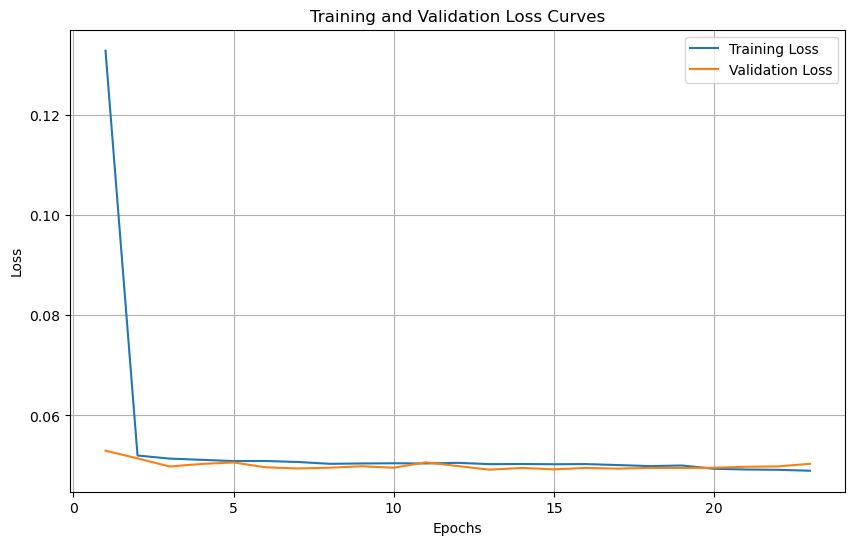

In [16]:
# Plot training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.grid(True)

In [21]:
alpha = {}
alpha_std = {}
alpha_significant = {}  
alpha_sums = {}

# Calculate alpha and alpha_std
for i in f_test.keys():
    alpha[i] = (f_test[i] * c_test[i]).mean(0)
    alpha_std[i] = (f_test[i] * c_test[i]).std(0)
    
    # Create mask for significant values (95% confidence = 1.96 standard deviations)
    is_significant = np.abs(alpha[i]) > 1.96 * alpha_std[i]
    
    # Zero out non-significant values
    alpha_significant[i] = np.where(is_significant, alpha[i], 0)
    
    # Calculate sum of absolute values for each key
    alpha_sums[i] = np.abs(alpha_significant[i]).sum()

In [22]:
alpha_sums

{0: np.float32(0.0050747157),
 1: np.float32(6.298401),
 2: np.float32(0.0035508587),
 3: np.float32(7.255304)}

# Interpretability

In [23]:
alpha = {}
alpha_std = {}
for i in f_test.keys():
    if i==0:
        alpha_bias = (f_test[0] * c_test[0]).mean(0)  # Mean of bias alpha coefficients
        alpha_bias_std = (f_test[0] * c_test[0]).std(0)  # Std of bias alpha coefficients
    else:
        alpha[i] = (f_test[i] * c_test[i]).mean(0)  # Mean of regularn alpha coefficients
        alpha_std[i] = (f_test[i] * c_test[i]).std(0)  # Std of regularn alpha coefficients

In [24]:
# Compute beta_tilde_tmp, beta_tilde, and beta_tilde_std using NumPy
beta_tilde_linear_tmp = np.abs(f_test[1] * c_test[1]).sum(axis=-1)  # sum along the last axis
beta_tilde_linear = beta_tilde_linear_tmp.mean(axis=0)  # mean along the 0th axis
beta_tilde_linear_std = beta_tilde_linear_tmp.std(axis=0)  # std along the 0th axis

# Compute beta and beta_std
beta_linear = beta_tilde_linear / beta_tilde_linear.sum(1,keepdims=True)  # Normalize beta_tilde
beta_linear_std = (beta_tilde_linear_tmp / beta_tilde_linear_tmp.sum(axis=1, keepdims=True)).std(axis=0)  # std after normalization

In [25]:
# Compute beta_tilde_tmp, beta_tilde, and beta_tilde_std using NumPy
beta_tilde_cubic_tmp = np.abs(f_test[3] * c_test[3]).sum(axis=-1)  # sum along the last axis
beta_tilde_cubic = beta_tilde_cubic_tmp.mean(axis=0)  # mean along the 0th axis
beta_tilde_cubic_std = beta_tilde_cubic_tmp.std(axis=0)  # std along the 0th axis

# Compute beta and beta_std
beta_cubic = beta_tilde_cubic / beta_tilde_cubic.sum(1,keepdims=True)  # Normalize beta_tilde
beta_cubic_std = (beta_tilde_cubic_tmp / beta_tilde_cubic_tmp.sum(axis=1, keepdims=True)).std(axis=0)  # std after normalization

## $\alpha$ bias

In [26]:
print_bias(alpha_bias, alpha_bias_std, ground_truth_bias)

bias_1 = (0.00027736 ± 0.00000001), gt_bias_1 = 0.00000000
bias_2 = (0.0044149 ± 0.0000001), gt_bias_2 = 0.0000000
bias_3 = (-0.00038250 ± 0.00000002), gt_bias_3 = 0.00000000


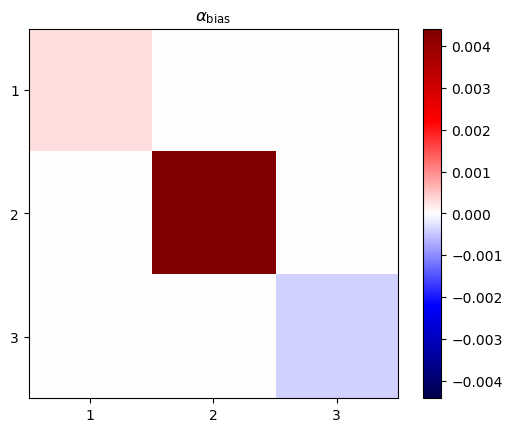

In [27]:
plot_bias(alpha_bias)

## $\alpha$ first order

In [28]:
print_significant_alpha(alpha[1], alpha_std[1],ground_truth_alpha_linear,threshold=0.02)

alpha_113 = (-2.634 ± 0.004), gt_alpha_113 = -2.750
alpha_225 = (-2.638 ± 0.004), gt_alpha_225 = -2.750
alpha_313 = (0.476 ± 0.009), gt_alpha_313 = 0.500
alpha_325 = (0.479 ± 0.007), gt_alpha_325 = 0.500


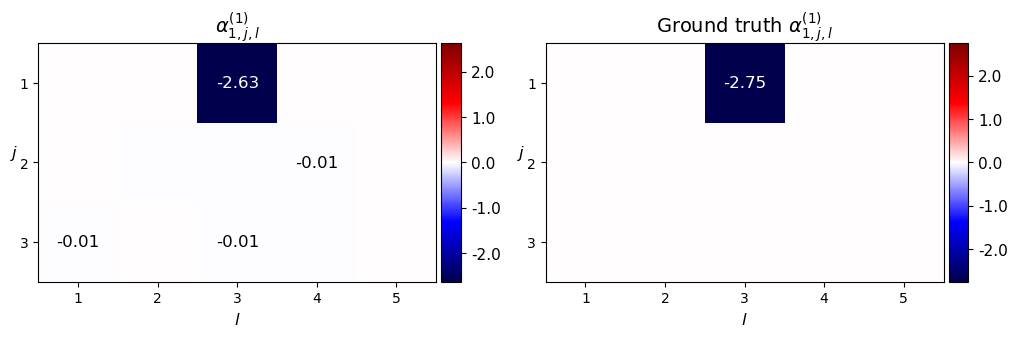

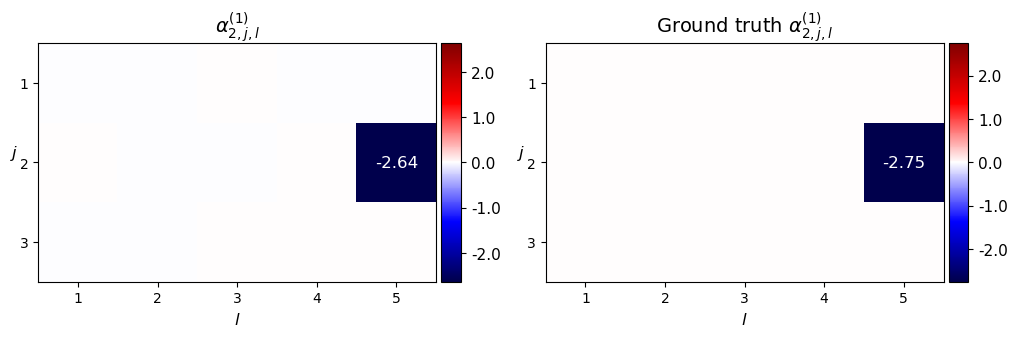

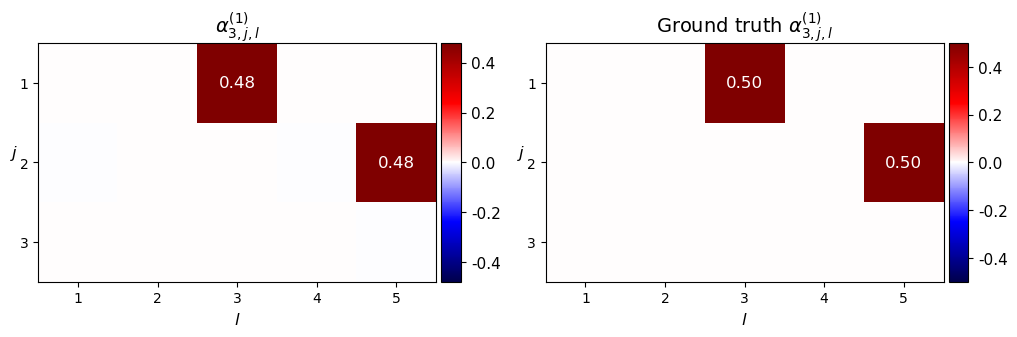

In [29]:
plot_alphas(alpha[1],ground_truth_alpha_linear, figsize=(6, 5), font_size=12, space=0.2, force_12=True, title=r'\alpha^{(1)}')

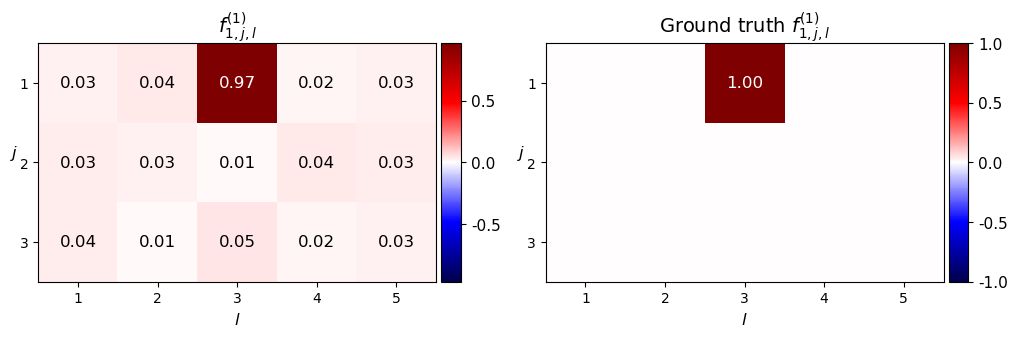

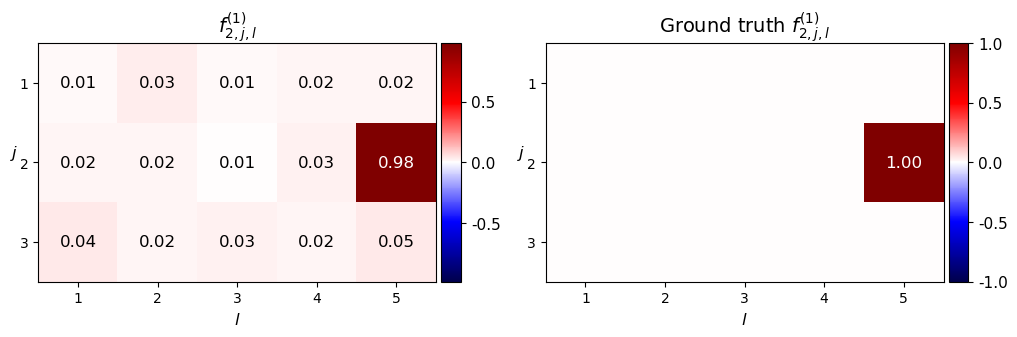

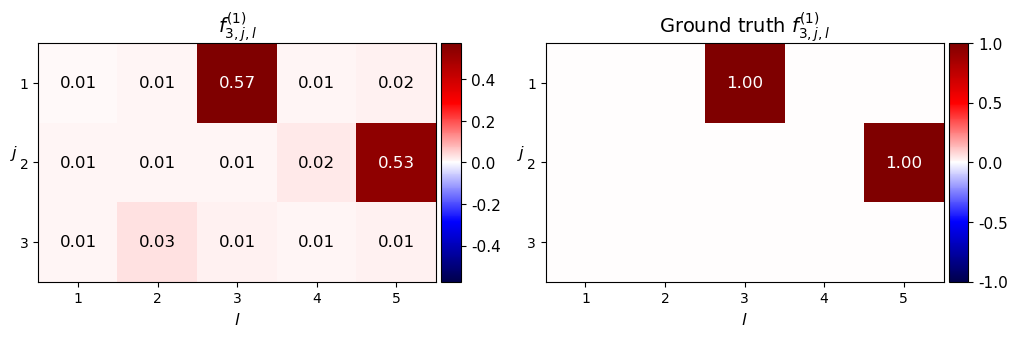

In [30]:
plot_alphas(f_test[1].mean(0),alpha_mask_linear, figsize=(6, 5), font_size=12, space=0.2, force_12=True, title=r'f^{(1)}')

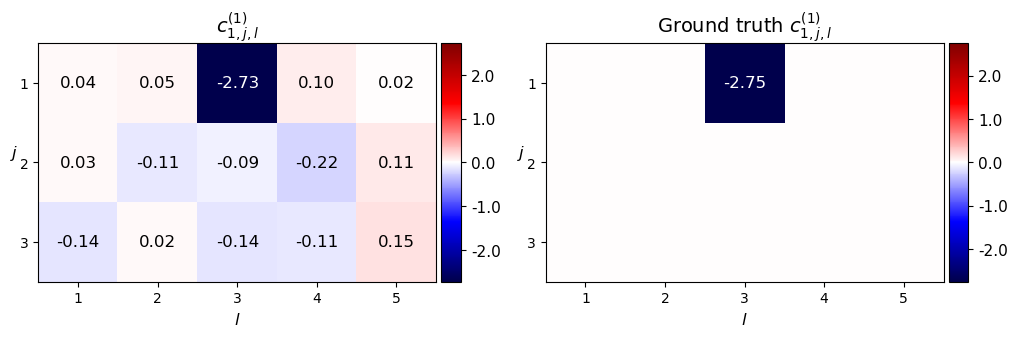

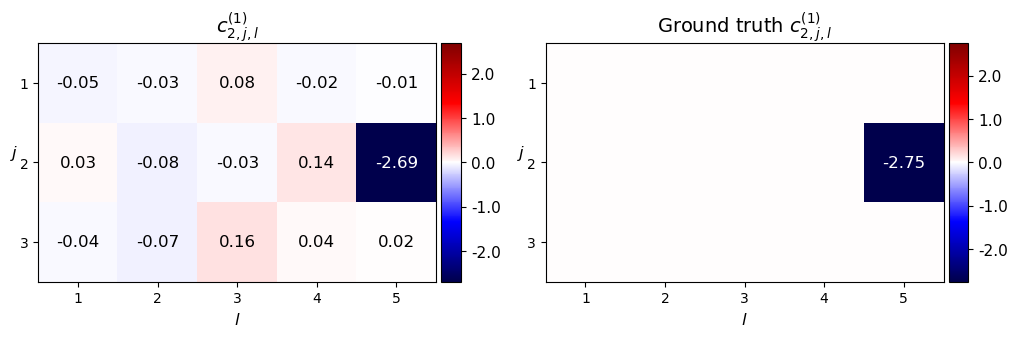

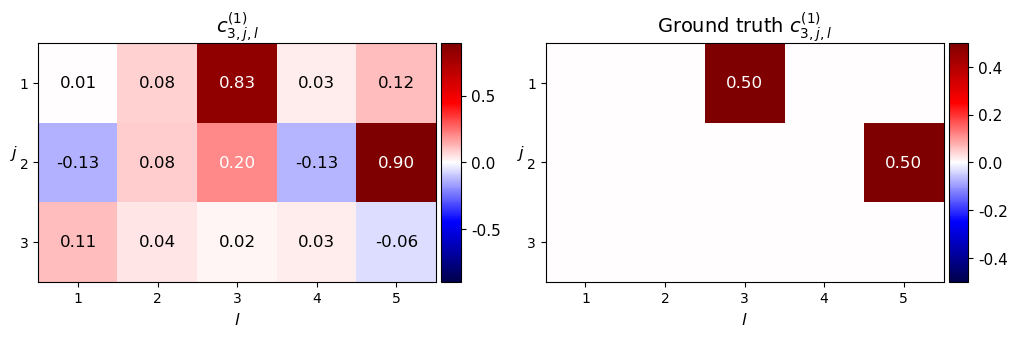

In [31]:
plot_alphas(c_test[1].mean(0),ground_truth_alpha_linear, figsize=(6, 5), font_size=12, space=0.2, force_12=True, title=r'c^{(1)}')

## $\alpha$ third order

In [34]:
print_significant_alpha(alpha[3], alpha_std[3],ground_truth_alpha_cubic,threshold=0.02)

alpha_113 = (3.573 ± 0.003), gt_alpha_113 = 3.750
alpha_225 = (3.594 ± 0.003), gt_alpha_225 = 3.750


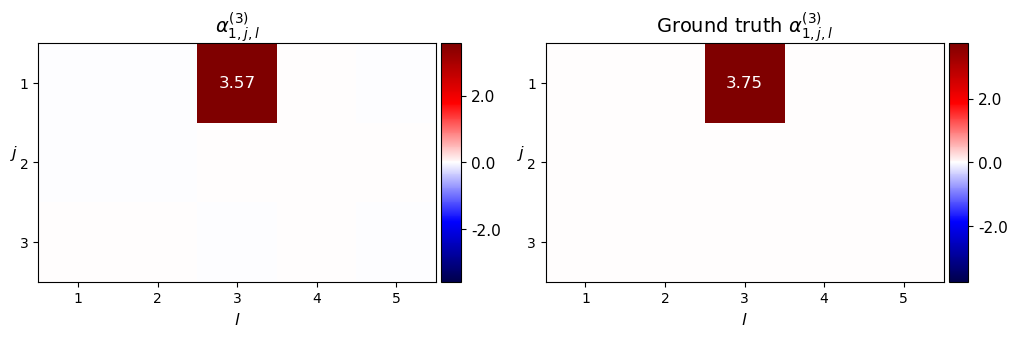

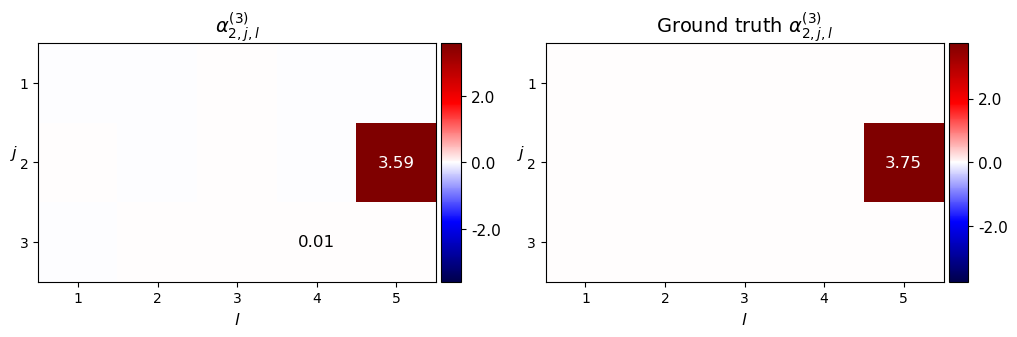

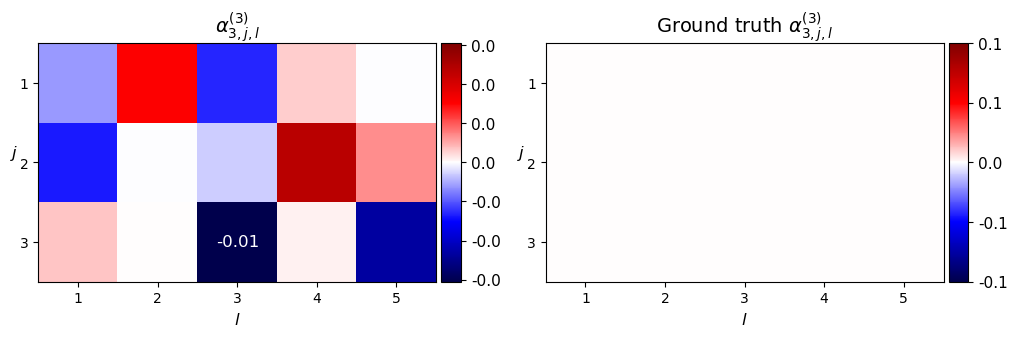

In [35]:
plot_alphas(alpha[3],ground_truth_alpha_cubic, figsize=(6, 5), font_size=12, space=0.2, force_12=True, title=r'\alpha^{(3)}')

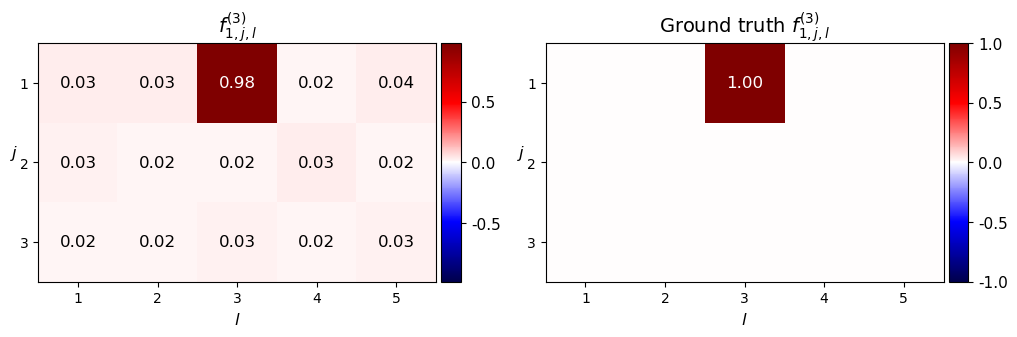

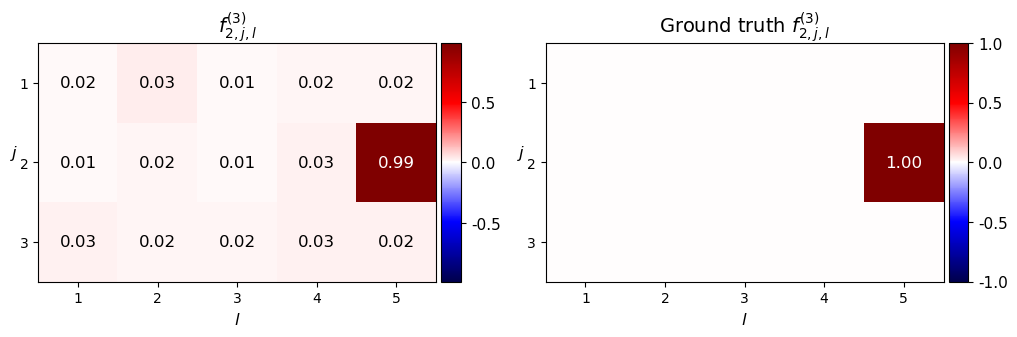

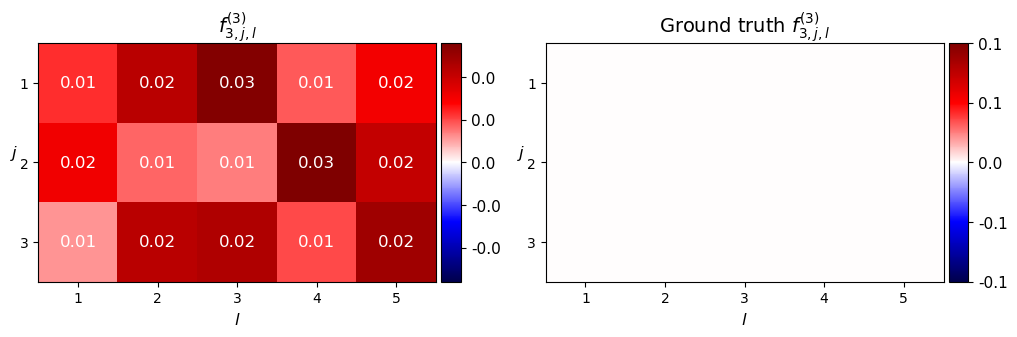

In [36]:
plot_alphas(f_test[3].mean(0),alpha_mask_cubic, figsize=(6, 5), font_size=12, space=0.2, force_12=True, title=r'f^{(3)}')

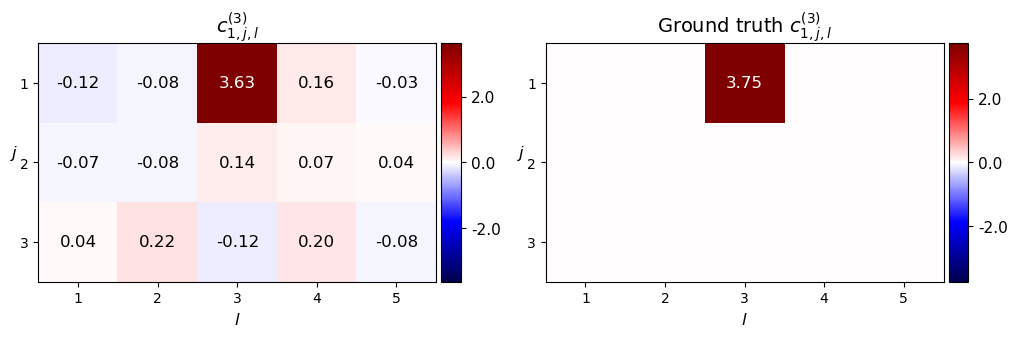

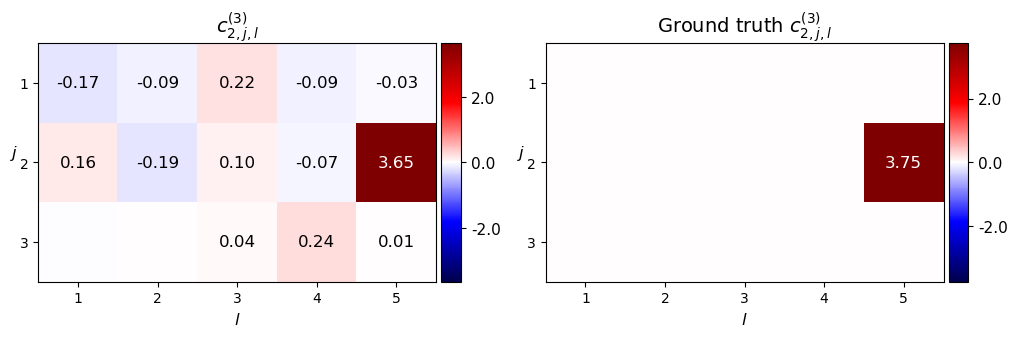

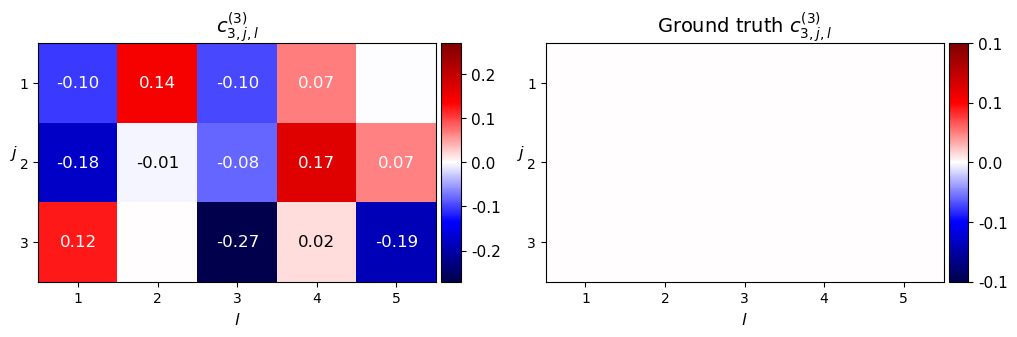

In [37]:
plot_alphas(c_test[3].mean(0),ground_truth_alpha_cubic, figsize=(6, 5), font_size=12, space=0.2, force_12=True, title=r'c^{(3)}')

# Test stabitliy on multiple runs

In [40]:
# Do not print train/eval output
train_config['verbose'] = False

# Collect results from multiple runs
results = collect_multiple_runs(
    n_runs=5,
    time_series=time_series,
    window_size=5,
    temperature=1.0,
    order=order_list,
    config=train_config,
    verbose=True
)

Training Configuration:
  verbose: False
  device: cuda:0
  learning_rate: 0.001
  scheduler_patience: 5
  early_stopping_modifier: 2
  epochs: 40
  criterion: MSELoss()
Starting Run 1/5
Run 1 completed. Test Loss: 5.150517e-02
Starting Run 2/5
Run 2 completed. Test Loss: 5.133528e-02
Starting Run 3/5
Run 3 completed. Test Loss: 5.156204e-02
Starting Run 4/5
Run 4 completed. Test Loss: 5.161456e-02
Starting Run 5/5
Run 5 completed. Test Loss: 5.145904e-02
Time taken for Run 4: 76.32 seconds


In [41]:
stats = calculate_multiple_run_statistics(results)

In [42]:
print_bias(stats['alpha_bias']['mean'],stats['alpha_bias']['std'], ground_truth_bias)

bias_1 = (-0.002 ± 0.005), gt_bias_1 = 0.000
bias_2 = (-0.001 ± 0.003), gt_bias_2 = 0.000
bias_3 = (0.004 ± 0.007), gt_bias_3 = 0.000


In [43]:
print_significant_alpha(stats['alpha'][1]['mean'], stats['alpha'][1]['std'],ground_truth_alpha_linear, threshold=0.02)

alpha_113 = (-2.642 ± 0.010), gt_alpha_113 = -2.750
alpha_225 = (-2.63 ± 0.01), gt_alpha_225 = -2.75
alpha_313 = (0.47 ± 0.01), gt_alpha_313 = 0.50
alpha_325 = (0.483 ± 0.004), gt_alpha_325 = 0.500


In [50]:
print_significant_alpha(stats['alpha'][2]['mean'], stats['alpha'][2]['std'],torch.zeros_like(ground_truth_alpha_linear), threshold=0.01)

In [45]:
# Create mask for significant values (95% confidence = 1.96 standard deviations)
is_significant = np.abs(stats['alpha'][2]['mean']) > 1.96 * stats['alpha'][2]['std']

# Zero out non-significant values
np.round(np.where(is_significant, stats['alpha'][2]['mean'], 0),4)

array([[[ 0.0037,  0.    ,  0.    ,  0.    ,  0.    ],
        [ 0.    ,  0.    , -0.0018,  0.    ,  0.    ],
        [ 0.    ,  0.0077, -0.0075,  0.0023, -0.004 ]],

       [[ 0.    ,  0.    , -0.0035,  0.    ,  0.    ],
        [ 0.    ,  0.    ,  0.    ,  0.    ,  0.0038],
        [ 0.0073,  0.    ,  0.    ,  0.0055, -0.0019]],

       [[ 0.    ,  0.    ,  0.    ,  0.    ,  0.0059],
        [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ],
        [ 0.0048,  0.    ,  0.    ,  0.    ,  0.    ]]], dtype=float32)

In [46]:
print_significant_alpha(stats['alpha'][3]['mean'], stats['alpha'][3]['std'],ground_truth_alpha_cubic, threshold=0.02)

alpha_113 = (3.59 ± 0.01), gt_alpha_113 = 3.75
alpha_225 = (3.582 ± 0.010), gt_alpha_225 = 3.750


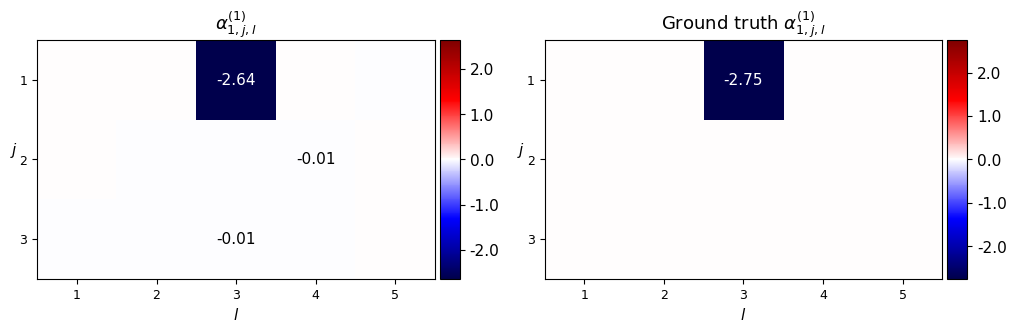

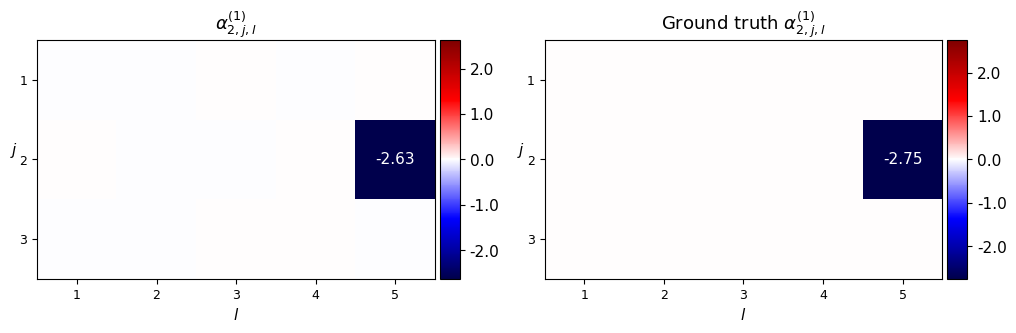

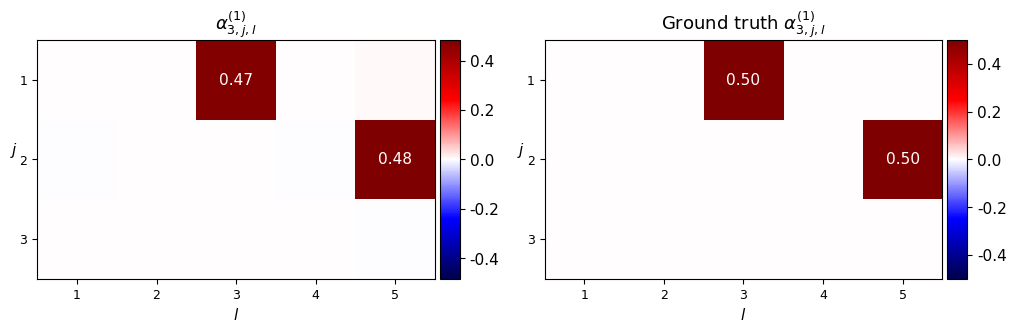

In [47]:
plot_alphas(stats['alpha'][1]['mean'],ground_truth_alpha_linear, figsize=(6, 5), title=r'\alpha^{(1)}', font_size=11, space=0.2, force_12=True)

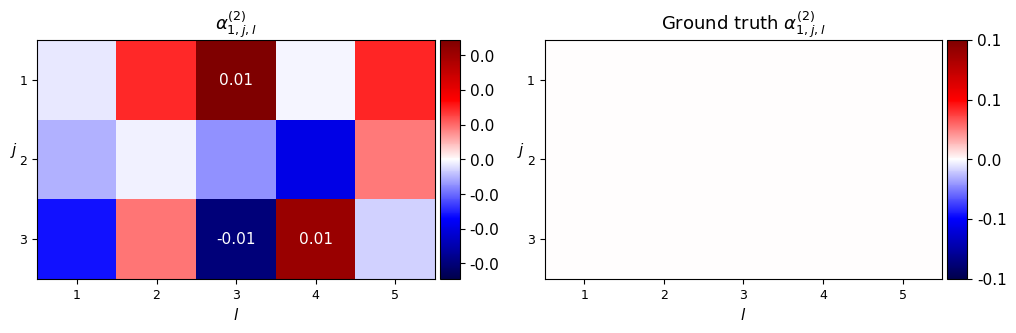

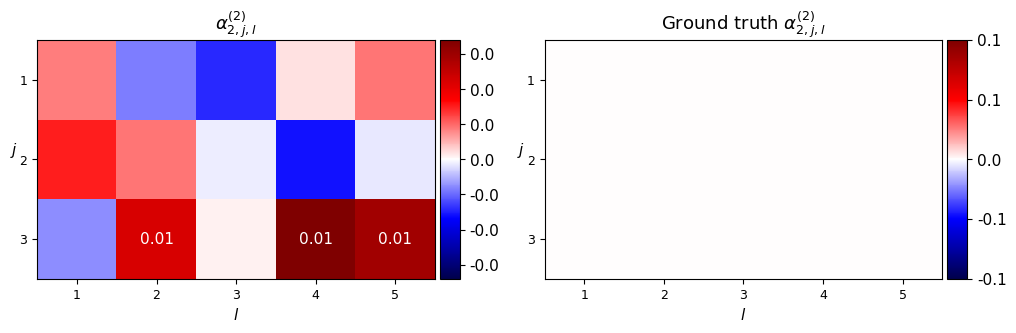

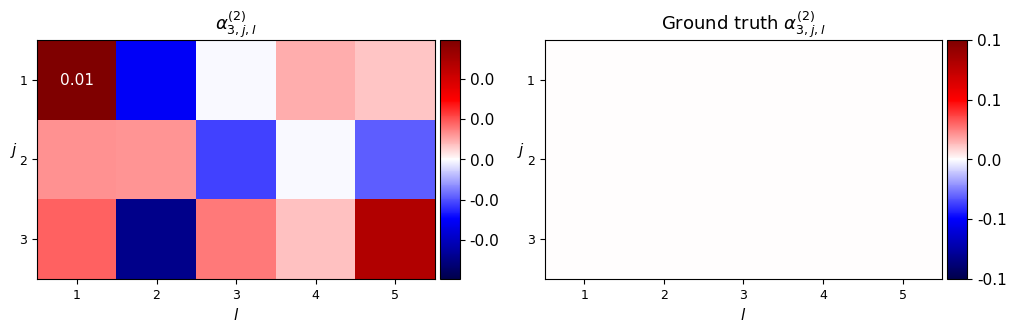

In [48]:
plot_alphas(stats['alpha'][2]['mean'],torch.zeros_like(ground_truth_alpha_linear), figsize=(6, 5), title=r'\alpha^{(2)}', font_size=11, space=0.2, force_12=True)

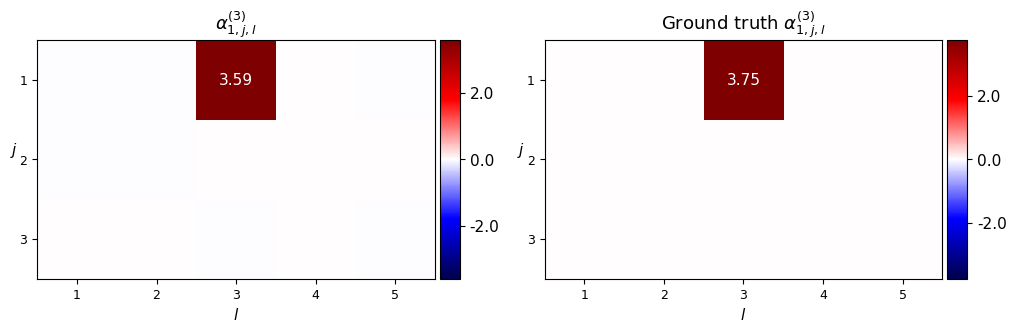

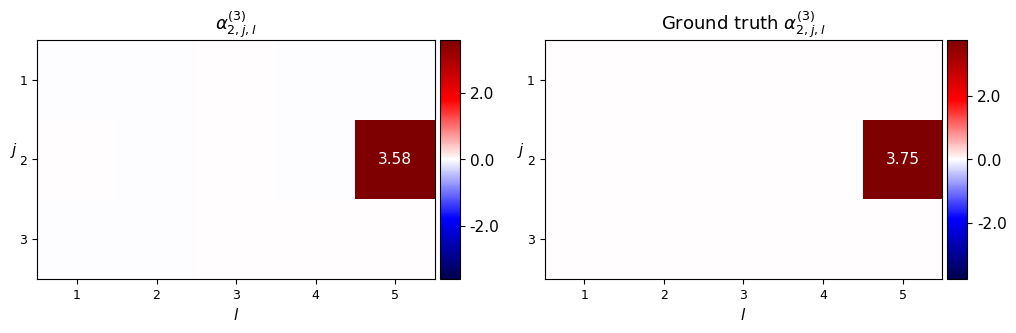

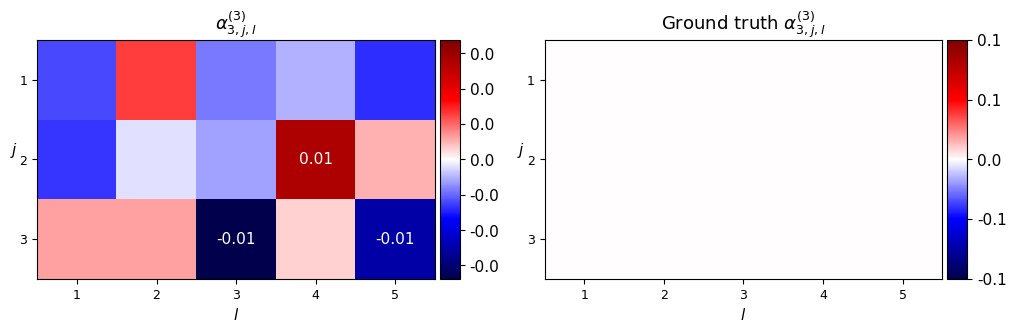

In [49]:
plot_alphas(stats['alpha'][3]['mean'],ground_truth_alpha_cubic, figsize=(6, 5), title=r'\alpha^{(3)}', font_size=11, space=0.2, force_12=True)